In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import fftpack
from scipy import signal

In [312]:
sampling_rate = 4000
gain = 12
v_ref = 4.5
resolution = (2**23) - 1

In [313]:
channel_offset = np.load('data/channel_data_differential.npy')
df = pd.DataFrame(data=channel_offset.T).set_index(0)
df = (df * v_ref) / resolution
df /= gain
df.columns = "channel_" + df.columns.astype(str)
df.index.name = "timestamp"
df.index -= min(df.index)
df.index /= 10**6
df = df - df.mean(axis=0)

In [314]:
# Find FFT
N = len(df)
T = 1 / sampling_rate
x = np.linspace(0.0, 1.0/(2.0*T), N//2)
df_fft = df.apply(scipy.fftpack.fft, axis=0, raw=True)

In [315]:
# Bandpass filter
high = 20        # Remove DC-related noise
low = 400       # EMG harmonics above 400Hz are generally due to noise
b, a = scipy.signal.butter(4, [high,low], btype='bandpass', fs=sampling_rate)
butter_filter = lambda x: scipy.signal.filtfilt(b, a, x)
df_butter = df.apply(butter_filter, axis=0, raw=True)


N_butter = len(df_butter)
x_butter = np.linspace(0.0, 1.0/(2.0*T), N_butter//2)
df_butter_fft = df.apply(scipy.fftpack.fft, axis=0, raw=True)


In [316]:
# Comb filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 10.0
b_notch, a_notch = scipy.signal.iircomb(w0=notch_freq, Q=quality_factor, fs=sampling_rate, ftype='notch')
freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
comb_filter = lambda x: scipy.signal.filtfilt(b_notch, a_notch, x)
df_comb = df_butter.apply(comb_filter, axis=0, raw=True)

N_comb = len(df_comb.index)
x_comb = np.linspace(0.0, 1.0/(2.0*T), N_comb//2)
df_comb_fft = df.apply(scipy.fftpack.fft, axis=0, raw=True)

In [317]:
# Find noise floor
noise_data = np.load('data/channel_noise_external.npy')
df_n = pd.DataFrame(data=noise_data.T).set_index(0)
df_n = (df_n * v_ref) / resolution
df_n /= gain
df_n.columns = "channel_" + df_n.columns.astype(str)
df_n.index.name = "timestamp"
df_n.index -= min(df_n.index)
df_n.index /= 10**6

noise = df_n.channel_3
noise = noise.to_numpy()
noise = noise - noise.mean()

# Bandpass filter
high = 20        # Remove DC-related noise
low = 400       # EMG harmonics above 400Hz are generally due to noise
b, a = scipy.signal.butter(4, [high,low], btype='bandpass', fs=sampling_rate)
noise = scipy.signal.filtfilt(b, a, noise)

# Comb filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 5.0
b_notch, a_notch = scipy.signal.iircomb(w0=notch_freq, Q=quality_factor, fs=sampling_rate, ftype='notch')
freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
noise = scipy.signal.filtfilt(b_notch, a_notch, noise)

In [318]:
# Calculate SNR
power_s = 1/(len(y_notched)) * np.abs(y_notched)**2
power_n = 1/(len(noise)) * np.abs(noise)**2
l = min(len(y_notched), len(noise))
power_s = power_s[:l]
power_n = power_n[:l]
snr = 10*np.log10((np.abs(power_s - power_n))/power_n)      # SNR in dB
snr.mean()

26.342485311698297

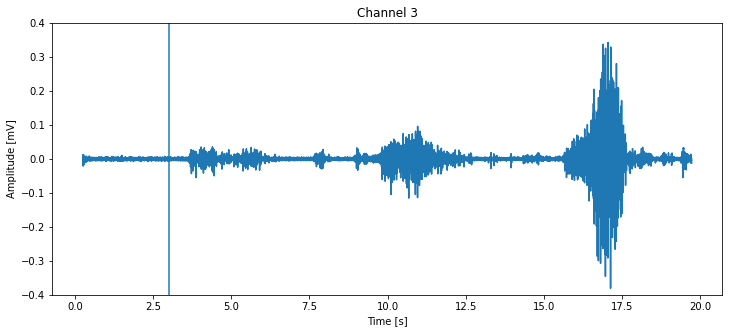

In [328]:
# Plot single channel
fig = plt.figure(figsize=(12,5))
plt.plot(df_comb.channel_3.iloc[1000:-1000]*1000)
plt.ylim(-0.4, 0.4)
plt.title('Channel 3')
plt.ylabel('Amplitude [mV]')
plt.xlabel('Time [s]')


In [323]:
timestamps = df_comb.index
flex = np.zeros((2,len(timestamps)))
for t in timestamps:
    


Float64Index([      0.0,     8e-05,  0.000308,  0.000557,  0.000807,  0.001057,
               0.001307,  0.001557,  0.001807,  0.002057,
              ...
               19.97362, 19.973871,  19.97412,  19.97437,  19.97462, 19.974867,
               19.97512,  19.97537,  19.97562, 19.975867],
             dtype='float64', name='timestamp', length=79978)


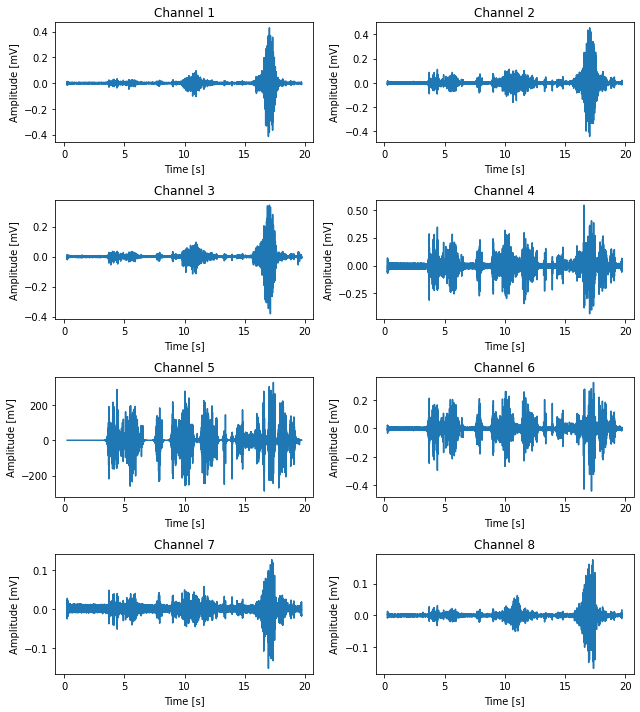

In [320]:
# Plot channels
plt.figure(figsize=(9,10))
for i, c in enumerate(df_comb.columns):
    plt.subplot(4, 2, i+1)
    df_comb[c].iloc[1000:-1000].multiply(1000).plot()
    plt.title('Channel ' + str(i+1))
    plt.ylabel('Amplitude [mV]')
    plt.xlabel('Time [s]')
plt.tight_layout()

Text(0, 0.5, 'Arbitrary unit')

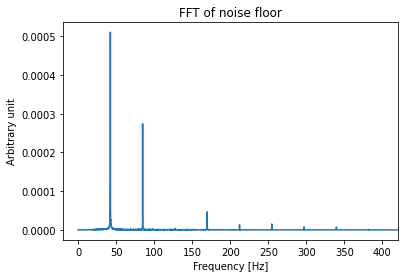

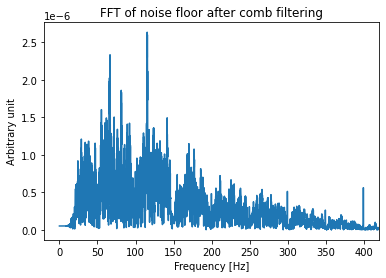

In [321]:
# FFT Plots

fig = plt.figure()
plt.plot(x_butter, 2.0/N_butter * np.abs(y_butter_fft[:N_butter//2]))
plt.xlim(-20, 420)
# plt.ylim(-1e-7, 9e-6)
plt.title('FFT of noise floor')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary unit')

fig = plt.figure()
plt.plot(x_notched, 2.0/N_notched * np.abs(y_notched_fft[:N_notched//2]))
plt.xlim(-20, 420)
# plt.ylim(-1e-7, 9e-6)
plt.title('FFT of noise floor after comb filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary unit')